In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import keras
import scipy.ndimage as ndi
from PIL import Image as pil_image
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x

In [3]:
def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

In [4]:
def apply_transform(x,
                    transform_matrix,
                    channel_axis=0,
                    fill_mode='nearest',
                    cval=0.):
    """Apply the image transformation specified by a matrix.

  Arguments:
      x: 2D numpy array, single image.
      transform_matrix: Numpy array specifying the geometric transformation.
      channel_axis: Index of axis for channels in the input tensor.
      fill_mode: Points outside the boundaries of the input
          are filled according to the given mode
          (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
      cval: Value used for points outside the boundaries
          of the input if `mode='constant'`.

  Returns:
      The transformed version of the input.
  """
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [
      ndi.interpolation.affine_transform(
          x_channel,
          final_affine_matrix,
          final_offset,
          order=0,
          mode=fill_mode,
          cval=cval) for x_channel in x
    ]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

In [5]:
def random_transform(x):
    transform_matrix=None
    
    """Randomly augment a single image tensor.

    Arguments:
        x: 3D tensor, single image.

    Returns:
        A randomly transformed version of the input (same shape).

    Raises:
        ImportError: if Scipy is not available.
    """

    # x is a single image, so it doesn't have image number at index 0
    channel_axis = 3
    row_axis = 1
    col_axis = 2
    img_row_axis = row_axis - 1
    img_col_axis = col_axis - 1
    img_channel_axis = channel_axis - 1

    # use composition of homographies
    # to generate final transform that needs to be applied
    if True:
        tx = np.random.uniform(-0.125,
                             0.125) * x.shape[img_row_axis]
    else:
        tx = 0

    if True:
        ty = np.random.uniform(-0.125,
                             0.125) * x.shape[img_col_axis]
    else:
        ty = 0
    if tx != 0 or ty != 0:
        shift_matrix = np.array([[1, 0, tx], [0, 1, ty], [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = shift_matrix
        else:
            transform_matrix=np.dot(transform_matrix, shift_matrix)
    if transform_matrix is not None:
        h, w = x.shape[img_row_axis], x.shape[img_col_axis]
        transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
        x = apply_transform(
          x,
          transform_matrix,
          img_channel_axis)
    if True:
        if np.random.random() < 0.5:
            x = flip_axis(x, img_col_axis)
    return x

In [6]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [7]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            
            X_batch=Xd[idx,:]
            y_batch=yd[idx]
            for i in range(yd[idx].shape[0]):
                X_batch[i,:]=random_transform(X_batch[i,:])
            
            # create a feed dictionary for this batch
            feed_dict = {X: X_batch,
                         y: y_batch,
                         is_training: training_now }
            #feed_dict = {X: Xd[idx,:],
            #             y: yd[idx],
            #             is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct


In [8]:
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

In [9]:
from resnet import *

def my_model(X,y,is_training):
    logits=build_model(X,y,is_training=is_training)
    return logits
y_out = my_model(X,y,is_training)
total_loss= tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10),logits=y_out)+tf.losses.get_regularization_loss()
mean_loss = tf.reduce_mean(total_loss)
global_step = tf.Variable(0, trainable=False, name="Global_Step")
#boundaries = [1500,3000,6400]
#values=[0.01,0.001,0.0005,0.0001]
#learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)
learning_rate = tf.train.exponential_decay(0.01, global_step,  100,  decay_rate=0.9,staircase=True)
optimizer = tf.train.RMSPropOptimizer(learning_rate,decay=0.90,momentum=0.1)

(?, 32, 32, 16)
(?, 32, 32, 16)
(?, 32, 32, 16)
(?, 32, 32, 16)
(?, 32, 32, 16)
(?, 16, 16, 32)
(?, 16, 16, 32)
(?, 16, 16, 32)
(?, 16, 16, 32)
(?, 8, 8, 64)
(?, 8, 8, 64)
(?, 8, 8, 64)
(?, 8, 8, 64)
(?, 7, 7, 64)
(?, 10)


In [10]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 3.46 and accuracy of 0.094
Iteration 100: with minibatch training loss = 3.11 and accuracy of 0.17
Iteration 200: with minibatch training loss = 2.79 and accuracy of 0.27
Iteration 300: with minibatch training loss = 2.5 and accuracy of 0.28
Iteration 400: with minibatch training loss = 2.82 and accuracy of 0.31
Iteration 500: with minibatch training loss = 3.09 and accuracy of 0.25
Iteration 600: with minibatch training loss = 1.91 and accuracy of 0.41
Iteration 700: with minibatch training loss = 3.32 and accuracy of 0.23
Epoch 1, Overall loss = 2.62 and accuracy of 0.287


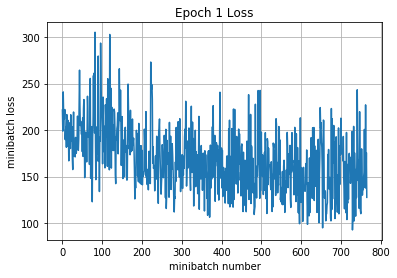

Iteration 800: with minibatch training loss = 2.39 and accuracy of 0.27
Iteration 900: with minibatch training loss = 2.03 and accuracy of 0.38
Iteration 1000: with minibatch training loss = 2.51 and accuracy of 0.33
Iteration 1100: with minibatch training loss = 1.81 and accuracy of 0.33
Iteration 1200: with minibatch training loss = 1.91 and accuracy of 0.44
Iteration 1300: with minibatch training loss = 1.53 and accuracy of 0.39
Iteration 1400: with minibatch training loss = 2.64 and accuracy of 0.45
Iteration 1500: with minibatch training loss = 2.06 and accuracy of 0.31
Epoch 2, Overall loss = 2.39 and accuracy of 0.354


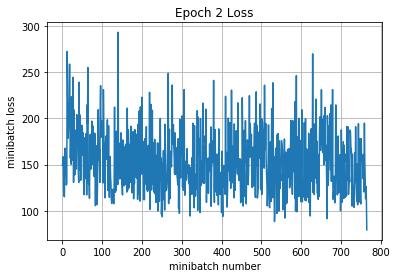

Iteration 1600: with minibatch training loss = 1.72 and accuracy of 0.45
Iteration 1700: with minibatch training loss = 2.66 and accuracy of 0.45
Iteration 1800: with minibatch training loss = 2.61 and accuracy of 0.38
Iteration 1900: with minibatch training loss = 2.13 and accuracy of 0.31


KeyboardInterrupt: 

In [11]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [ ]:
#should add some data augmentation later on